## Assignment-6 - AlexNet, ResNet50, RNN, GRU, and LSTM
***Taha Adeel Mohammed - CS20BTECH11052***

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE

In [2]:
torch.manual_seed(0)
np.random.seed(1)
# plt.style.use('dark_background')

# Uses GPU if available
# device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:0


### 1) Image Classification (CIFAR-10 dataset)

##### Loading the dataset

In [3]:
# Define the preprocessing steps
cifar_mean = [0.49139968, 0.48215827 ,0.44653124]
cifar_std = [0.24703233, 0.24348505, 0.26158768]
preprocess = transforms.Compose([
    transforms.Resize(256), # Rescale to 256x256, since AlexNet expects this size
    transforms.CenterCrop(224), # Heurestic assumption that the object is in the center of the image
    transforms.ToTensor(), # Convert to tensor in the range [0, 1]
    transforms.Normalize(cifar_mean, cifar_std), # Normalize to the range [-1, 1]
])

# Download the data
data = CIFAR10(root='./data', train=True, download=True, transform=preprocess)
data = ConcatDataset([data, CIFAR10(root='./data', train=False, download=True, transform=preprocess)])

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Print the dataset sizes
print(f'Dataset size: {len(data)}')

Files already downloaded and verified
Files already downloaded and verified
Dataset size: 60000


In [4]:
# Split data into 70:10:20 train, validation, test sets 
train_data, val_data, test_data = random_split(data, [0.7, 0.1, 0.2])

print(f'Train dataset size: {len(train_data)}')
print(f'Validation dataset size: {len(val_data)}')
print(f'Test dataset size: {len(test_data)}')

Train dataset size: 42000
Validation dataset size: 6000
Test dataset size: 12000


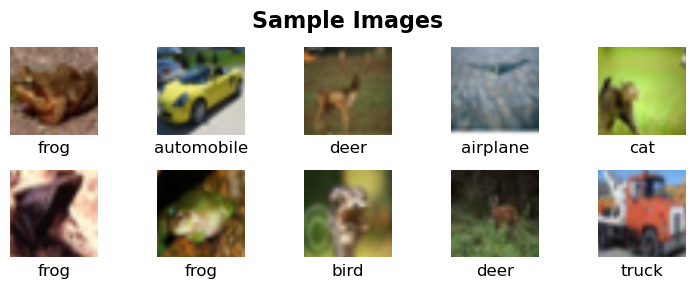

In [5]:
# Display a few images from the dataset
plt.figure(figsize=(7.5, 3))
plt.suptitle('Sample Images', y=0.95, fontweight='bold', fontsize=16)
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = train_data[i][0] * torch.tensor(cifar_std).view(3, 1, 1) + torch.tensor(cifar_mean).view(3, 1, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'{label_names[train_data[i][1]]}', y=-0.3)
    plt.axis('off')
plt.tight_layout()
plt.show()

##### Print model summary

In [30]:
def print_model_summary(model: nn.Module):
    total_params = sum(p.numel() for p in model.parameters())
    print('='*15)
    print(' Model Summary ', end='\n' + '='*15 + '\n')
    print(f'Total number of parameters: {total_params}')
    print(model)

##### (a, c) Training and accuracy functions

In [7]:
def train_loop(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, device: torch.device = torch.device('cpu'), verbose: bool = True):
    ''' Train the model for one epoch'''
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # Move data to device(GPU if present)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print the loss for 10 batches
        if verbose and batch % (max(len(dataloader)//10, 1)) == 0:
            loss, current = loss.item(), batch*len(X)
            print(f' Loss: {loss:>7f}      [{current:>5d}/{len(dataloader.dataset)}]')
            
            
def get_loss_accuracy(dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, device: torch.device = torch.device('cpu')) -> tuple[float, float]:
    ''' Evaluate the model on the given set and return the loss and accuracy'''
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) # Move data to device(GPU if present)
            
            # Compute prediction and loss
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    return loss/len(dataloader), 100*correct/len(dataloader.dataset)


def plot_errors(train_errors: list, val_errors: list, train_accuracies: list, val_accuracies: list, title: str = 'Model Training Progress'):
    ''' Plot the test and validation errors vs epochs'''
    num_epochs = len(train_errors)
    
    plt.figure(figsize=(12, 2.8))
    plt.suptitle(title, y=1.03, fontweight='bold', fontsize=13)
    
    # Plot the test and validation errors
    plt.subplot(1, 2, 1)
    plt.title('Errors vs Epochs')
    plt.plot(np.arange(1, num_epochs+1), train_errors, label='Train Error')
    plt.plot(np.arange(1, num_epochs+1), val_errors, label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, num_epochs+1))
    
    # Plot the best validation error
    min_val_error = min(val_errors)
    min_val_error_epoch = val_errors.index(min_val_error)+1
    plt.axvline(min_val_error_epoch, linestyle='dotted', color='pink', label=f'Best Epoch: {min_val_error_epoch}')
    plt.scatter(min_val_error_epoch, min_val_error, marker='*', label=f'Min Validation Error: {min_val_error:.2f}', color='red')
    plt.legend()
    
    # Plot the test and validation accuracies
    plt.subplot(1, 2, 2)
    plt.title('Accuracies vs Epochs')
    plt.plot(np.arange(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(np.arange(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, num_epochs+1))
    
    plt.show()

##### (b) Visualizing activation maps

In [8]:
_activation_volumes_hook = []
def set_activation_volume_hook(module, input, output):
    ''' Hook to get the activation volume of the layer'''
    _activation_volumes_hook.append(output.cpu().detach().numpy())
    
    
def get_activation_volumes(model: nn.Module, layers: list, dataloader: DataLoader, device: torch.device = torch.device('cpu')):
    ''' Get the activation volumes of the given layers for a sample image'''
    # Register the hook for the given layers
    handles = []
    for layer in layers:
        handles.append(layer.register_forward_hook(set_activation_volume_hook))
    
    # Get a sample image
    X, y = next(iter(dataloader))
    idx = np.random.randint(X.shape[0])
    X = X[idx].unsqueeze(0).to(device)
    img = X[0].cpu().detach().numpy().transpose(1, 2, 0) * np.array(cifar_std) + np.array(cifar_mean)
    
    # Get the activation volumes, which are computed through the forward hook calls
    model.eval()
    with torch.no_grad():
        model(X)
    
    # Remove the hooks and reset the activation_volumes
    for handle in handles:
        handle.remove()
    activation_volumes = _activation_volumes_hook.copy()
    _activation_volumes_hook.clear()
    
    return img, y[idx].item(), activation_volumes


def plot_activation_volumes(img: np.array, label: int, activations: list, layer_names: list, num_channels: int, title: str = 'Activation Volumes'):
    ''' Plot the activation volumes of the layers'''
    num_layers = len(activations)
    img_dims = (img.shape[2], img.shape[0], img.shape[1])
    
    fig = plt.figure(figsize=(num_channels*1.2, num_layers*1.6))
    subfigs = fig.subfigures(1+num_layers, 1, wspace=0.07, hspace=0.15)
    fig.suptitle(title, y=1.05, fontweight='bold', fontsize=14)
    
    # Plot the image
    axs = subfigs[0].subplots(1, 1)
    subfigs[0].suptitle(f'Input Image -> {img_dims}', y=1.05, fontsize=12, fontweight='bold')
    axs.imshow(img)
    axs.set_title(f'{label_names[label]}', y=-0.25, fontsize=9)
    axs.axis('off')
    
    # Plot the activation maps
    for i in range(num_layers):
        axs = subfigs[i+1].subplots(1, num_channels)
        subfigs[i+1].suptitle(f'{layer_names[i]} -> {activations[i][0].shape}', y=1.02, fontsize=12, fontweight='bold')
        # For random selection of channels
        for j, channel in enumerate(sorted(np.random.choice(activations[i].shape[1], num_channels, replace=False))):
            axs[j].imshow(activations[i][0, channel])
            axs[j].set_title(f'Channel {channel}', y=-0.3, fontsize=9)
            axs[j].axis('off')
    
    plt.show()


def visualize_activation_maps(model: nn.Module, layers: list, layer_names: list, dataloader: DataLoader, num_channels: int = 6, num_images: int = 1, device: torch.device = torch.device('cpu')):
    ''' Visualize the activation maps of the given layers for the sample images'''
    for _ in range(num_images):
        img, label, activations = get_activation_volumes(model, layers, dataloader, device)
        plot_activation_volumes(img, label, activations, layer_names, num_channels)

#### (d) Visualizing the bottleneck feature (tSNE)

In [9]:
_bottleneck_features_hook = []
def set_bottleneck_features_hook(module, input, output):
    _bottleneck_features_hook.append(output.cpu().detach().numpy())


def get_bottleneck_features(model: nn.Module, bottleneck_layer: nn.Module, dataloader: DataLoader, device: torch.device = torch.device('cpu')):
    ''' Get the features of the given bottleneck layer for a sample batch of images'''
    handle = bottleneck_layer.register_forward_hook(set_bottleneck_features_hook)
    
    X, y = next(iter(dataloader))
    X = X.to(device)
    
    model.eval()
    with torch.no_grad():
        model(X)
    handle.remove()
    
    bottleneck_features = _bottleneck_features_hook.copy()
    _bottleneck_features_hook.clear()
    
    return bottleneck_features[0], y
    

def plot_tSNE_features(features: list, y_i: torch.Tensor, y_f: torch.Tensor, num_epochs: int, title: str = 't-SNE Embeddings of the Bottleneck Features'):
    ''' Plot the t-SNE features'''
    # Get the tSNE embeddings
    tsne = TSNE(n_components=2, perplexity=y_i.size()[0]//10, random_state=0)
    X_i = tsne.fit_transform(features[0].reshape(features[0].shape[0], -1))
    X_f = tsne.fit_transform(features[-1].reshape(features[-1].shape[0], -1))
    
    # Plot the embeddings
    plt.figure(figsize=(10, 4.8))
    plt.suptitle(title, fontweight='bold', fontsize=15)
    
    plt.subplot(1, 2, 1)
    plt.title('After epoch 1')
    plt.scatter(X_i[:, 0], X_i[:, 1], c=y_i.cpu().detach().numpy(), cmap=matplotlib.colormaps['jet'].resampled(10))
    plt.colorbar(ticks=range(10))
    plt.clim(-0.5, 9.5)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 2, 2)
    plt.title(f'After epoch {num_epochs}')
    plt.scatter(X_f[:, 0], X_f[:, 1], c=y_f.cpu().detach().numpy(), cmap=matplotlib.colormaps['jet'].resampled(10))
    plt.colorbar(ticks=range(10))
    plt.clim(-0.5, 9.5)
    plt.xticks([])
    plt.yticks([])
    
    plt.tight_layout()
    plt.show()

#### Model training

In [10]:
def train(train_dataloader: DataLoader, val_dataloader: DataLoader, model: nn.Module, bottleneck_layer: nn.Module, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, max_epochs: int, device: torch.device = torch.device('cpu'), verbose: int = 1):
    ''' Train the model for the given number of epochs, returning the train and validation 
        errors and accuracies vs epochs, and the t-SNE embeddings of the bottleneck features'''
    train_errors, val_errors = [], []
    train_accuracies, val_accuracies = [], []
    
    stopping_epoch = max_epochs
    for epoch in tqdm(range(max_epochs)):
        if epoch >= stopping_epoch: continue
        if verbose > 1: print('\n===================================')
        if verbose: print(f'Epoch {epoch+1:<2}', end=' ')
        if verbose > 1: print('\n===================================')
        
        # Train the model for one epoch
        train_loop(train_dataloader, model, loss_fn, optimizer, device, verbose > 1)
        
        # Get the bottleneck features after epoch 1
        if epoch == 0:
            bottleneck_features_i, y_i = get_bottleneck_features(model, bottleneck_layer, train_dataloader, device)
        
        # Get the train and validation errors and accuracies
        train_loss, train_acc = get_loss_accuracy(train_dataloader, model, loss_fn, device)
        val_loss, val_acc = get_loss_accuracy(val_dataloader, model, loss_fn, device)
        
        train_errors.append(train_loss)
        val_errors.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        if verbose:
            print(f'-> Train Error: {train_loss:.2f} | Validation Error: {val_loss:.2f} | Train Accuracy: {train_acc:.2f} | Validation Accuracy: {val_acc:.2f}')
        
        if epoch > 2 and val_errors[-1] > np.mean(val_errors[-3:-1]):
            if verbose: print(f'\nEarly stopping on epoch {epoch+1}')
            stopping_epoch = epoch+1

    
    # Get the bottleneck features after the last epoch
    bottleneck_features_f, y_f = get_bottleneck_features(model, bottleneck_layer, train_dataloader, device)
    
    return (train_errors, val_errors, train_accuracies, val_accuracies), ([bottleneck_features_i, bottleneck_features_f], y_i, y_f), stopping_epoch # For (a) and (d)

#### 1) AlexNet

In [11]:
# Load the model
alexnet_classifier = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights=None).to(device)

print_model_summary(alexnet_classifier)

Using cache found in /home/taha_adeel/.cache/torch/hub/pytorch_vision_v0.10.0


 Model Summary 
Total number of parameters: 61100840
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Lin

##### Train the model

In [12]:
# Training parameters
max_epochs = 15
loss_fn = nn.CrossEntropyLoss()
batch_size_alex = 128
learning_rate_alex = 0.0001
optimizer_alex = torch.optim.Adam(alexnet_classifier.parameters(), lr=learning_rate_alex)

# Create the dataloaders
num_workers = 6 # Number of processes to use for data loading
train_loader = DataLoader(train_data, batch_size=batch_size_alex, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size_alex, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size_alex, shuffle=True, num_workers=num_workers, drop_last=True)

bottleneck_layer = alexnet_classifier.features[-1] # Get the last layer of the features

# Train the model
errors_alex, bottleneck_features_alex, epochs_alex = train(train_loader, val_loader, alexnet_classifier, bottleneck_layer, loss_fn, optimizer_alex, max_epochs, device, verbose=1)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 -> Train Error: 1.51 | Validation Error: 1.52 | Train Accuracy: 44.63 | Validation Accuracy: 42.88
Epoch 2 -> Train Error: 1.15 | Validation Error: 1.17 | Train Accuracy: 58.67 | Validation Accuracy: 56.78
Epoch 3 -> Train Error: 0.98 | Validation Error: 1.02 | Train Accuracy: 65.62 | Validation Accuracy: 63.05
Epoch 4 -> Train Error: 0.79 | Validation Error: 0.87 | Train Accuracy: 72.34 | Validation Accuracy: 67.85
Epoch 5 -> Train Error: 0.71 | Validation Error: 0.82 | Train Accuracy: 75.01 | Validation Accuracy: 69.53
Epoch 6 -> Train Error: 0.58 | Validation Error: 0.72 | Train Accuracy: 80.41 | Validation Accuracy: 73.57
Epoch 7 -> Train Error: 0.51 | Validation Error: 0.69 | Train Accuracy: 82.38 | Validation Accuracy: 74.72
Epoch 8 -> Train Error: 0.42 | Validation Error: 0.65 | Train Accuracy: 85.37 | Validation Accuracy: 76.62
Epoch 9 -> Train Error: 0.37 | Validation Error: 0.62 | Train Accuracy: 87.57 | Validation Accuracy: 77.10
Epoch 10 -> Train Error: 0.31 | Valid

##### (a) Plot the errors

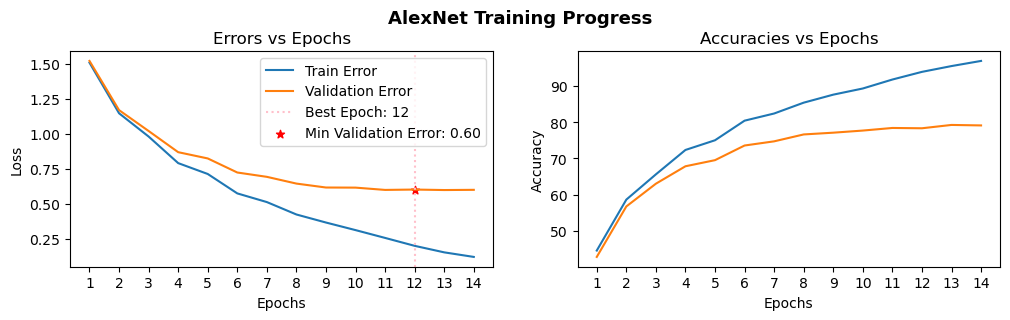

In [13]:
plot_errors(*errors_alex, title='AlexNet Training Progress')

##### (b) Visualizing activation maps

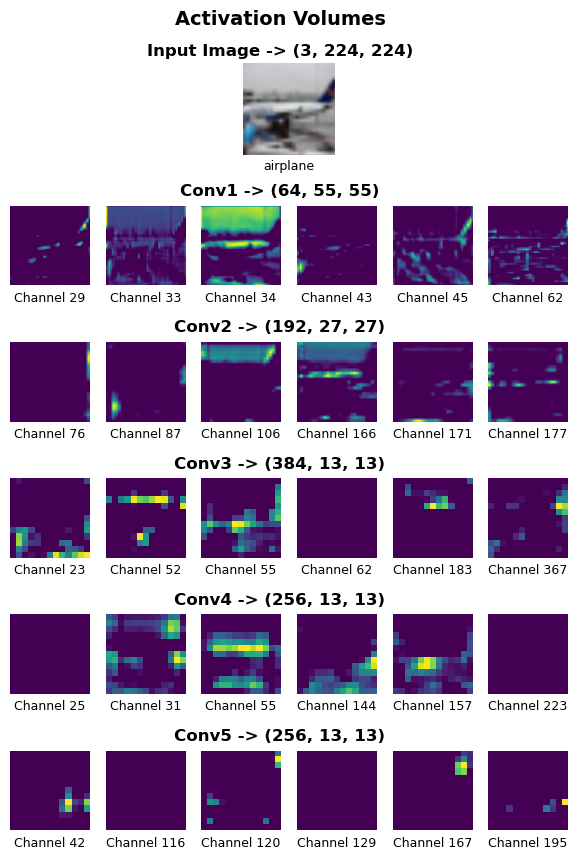

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


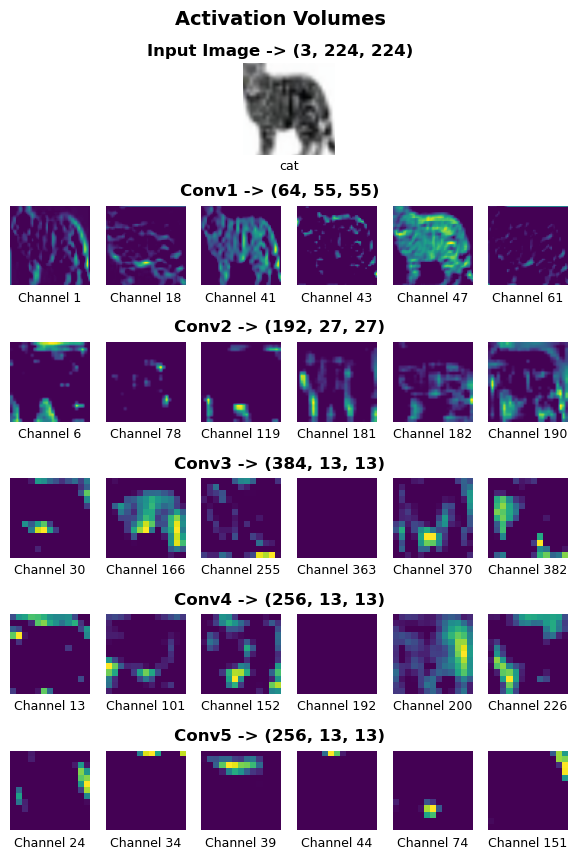

In [14]:
num_images = 2 # Number of images to plot
num_channels = 6 # Number of channels to plot for each layer
conv_layers = [alexnet_classifier.features[1], alexnet_classifier.features[4], alexnet_classifier.features[7], alexnet_classifier.features[9], alexnet_classifier.features[11]]
conv_layer_names = ['Conv1', 'Conv2', 'Conv3', 'Conv4', 'Conv5']

visualize_activation_maps(alexnet_classifier, conv_layers, conv_layer_names, train_loader, num_channels, num_images, device=device)

##### (c) Reporting the accuracy

In [15]:
train_loss_alex, train_acc_alex = get_loss_accuracy(train_loader, alexnet_classifier, loss_fn, device)
val_loss_alex, val_acc_alex = get_loss_accuracy(val_loader, alexnet_classifier, loss_fn, device)
test_loss_alex, test_acc_alex = get_loss_accuracy(test_loader, alexnet_classifier, loss_fn, device)

print(f'Train Accuracy: {train_acc_alex:.2f}% | Validation Accuracy: {val_acc_alex:.2f}% | Test Accuracy: {test_acc_alex:.2f}%')

Train Accuracy: 96.86 | Validation Accuracy: 79.20 | Test Accuracy: 80.69


##### (d) Visualizing the bottleneck feature (tSNE)

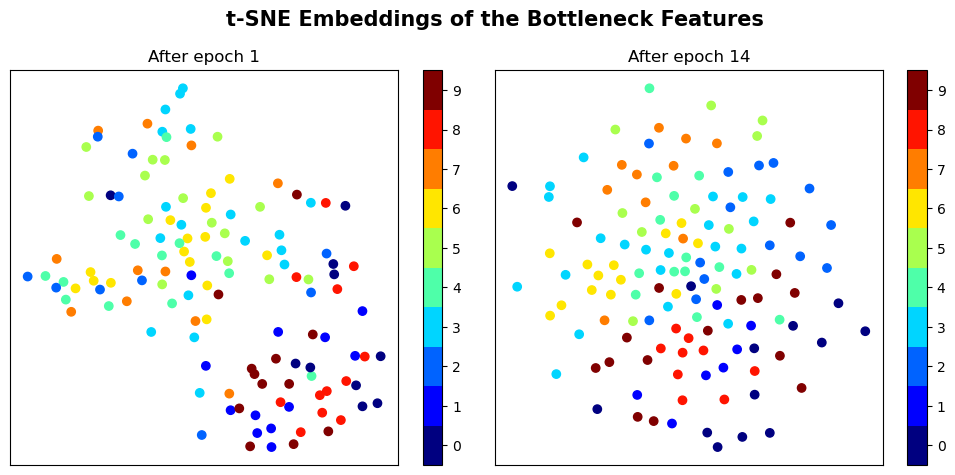

In [16]:
plot_tSNE_features(*bottleneck_features_alex, num_epochs=epochs_alex, title='t-SNE Embeddings of the Bottleneck Features')

In [17]:
# Free up GPU memory
del alexnet_classifier

#### (ii) ResNet50

In [18]:
resnet50_classifier = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None).to(device)

print_model_summary(resnet50_classifier)

Using cache found in /home/taha_adeel/.cache/torch/hub/pytorch_vision_v0.10.0


 Model Summary 
Total number of parameters: 25557032
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
       

##### Train the model

In [19]:
# Training parameters
max_epochs = 15
loss_fn = nn.CrossEntropyLoss()
batch_size_resnet = 20
learning_rate_resnet = 0.0001
optimizer_resnet = torch.optim.Adam(resnet50_classifier.parameters(), lr=learning_rate_resnet)

# Create the dataloaders
num_workers = 6 # Number of processes to use for data loading
train_loader = DataLoader(train_data, batch_size=batch_size_resnet, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size_resnet, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size_resnet, shuffle=True, num_workers=num_workers, drop_last=True)

bottleneck_layer = resnet50_classifier.layer4[-1].relu # Get the last layer of the layer4

# Train the model
errors_resnet, bottleneck_features_resnet, epochs_resnet = train(train_loader, val_loader, resnet50_classifier, bottleneck_layer, loss_fn, optimizer_resnet, max_epochs, device, verbose=2)

  0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1 
 Loss: 7.060716      [    0/42000]
 Loss: 1.904211      [ 4200/42000]
 Loss: 1.931260      [ 8400/42000]
 Loss: 1.475606      [12600/42000]
 Loss: 1.449686      [16800/42000]
 Loss: 1.709871      [21000/42000]
 Loss: 1.838922      [25200/42000]
 Loss: 1.248344      [29400/42000]
 Loss: 1.690468      [33600/42000]
 Loss: 1.421616      [37800/42000]
-> Train Error: 1.35 | Validation Error: 1.37 | Train Accuracy: 51.85 | Validation Accuracy: 51.53

Epoch 2 
 Loss: 1.162052      [    0/42000]
 Loss: 1.466212      [ 4200/42000]
 Loss: 1.520118      [ 8400/42000]
 Loss: 1.179692      [12600/42000]
 Loss: 1.075218      [16800/42000]
 Loss: 0.989851      [21000/42000]
 Loss: 0.895251      [25200/42000]
 Loss: 1.060222      [29400/42000]
 Loss: 0.910733      [33600/42000]
 Loss: 1.474365      [37800/42000]
-> Train Error: 0.99 | Validation Error: 1.06 | Train Accuracy: 65.46 | Validation Accuracy: 62.90

Epoch 3 
 Loss: 0.922938      [    0/42000]
 Loss: 0.797288      [ 4200/42000]
 L

##### (a) Plot the errors

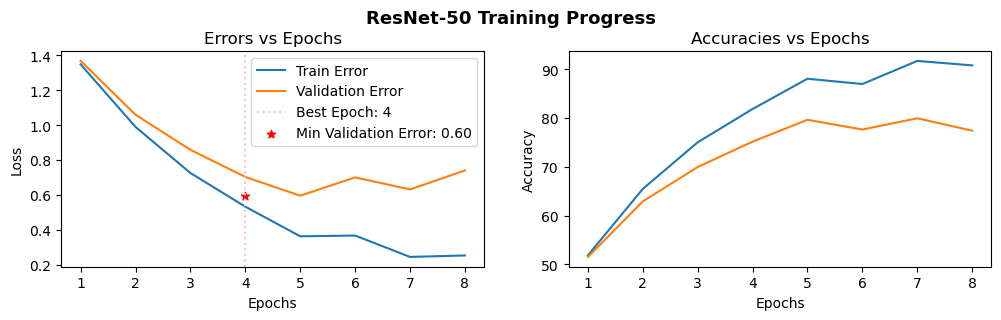

In [20]:
plot_errors(*errors_resnet, title='ResNet-50 Training Progress')

##### (b) Visualizing activation maps

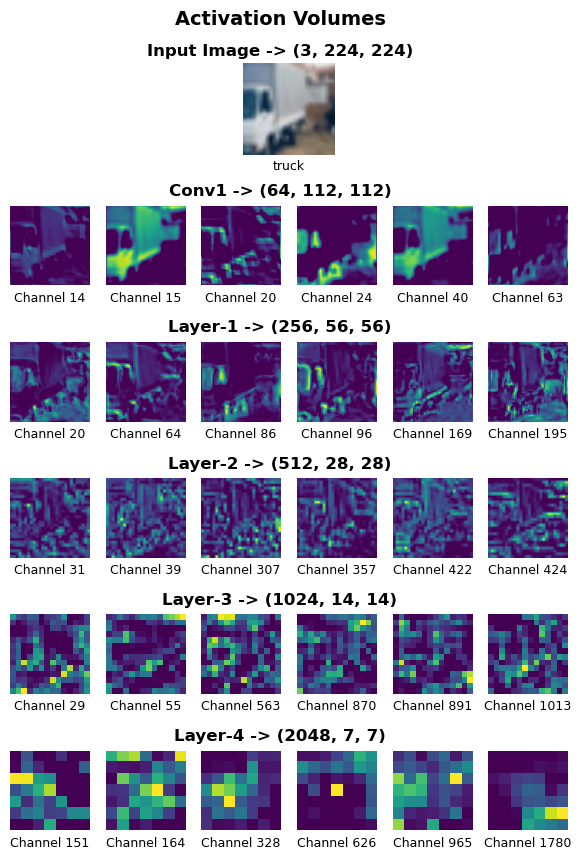

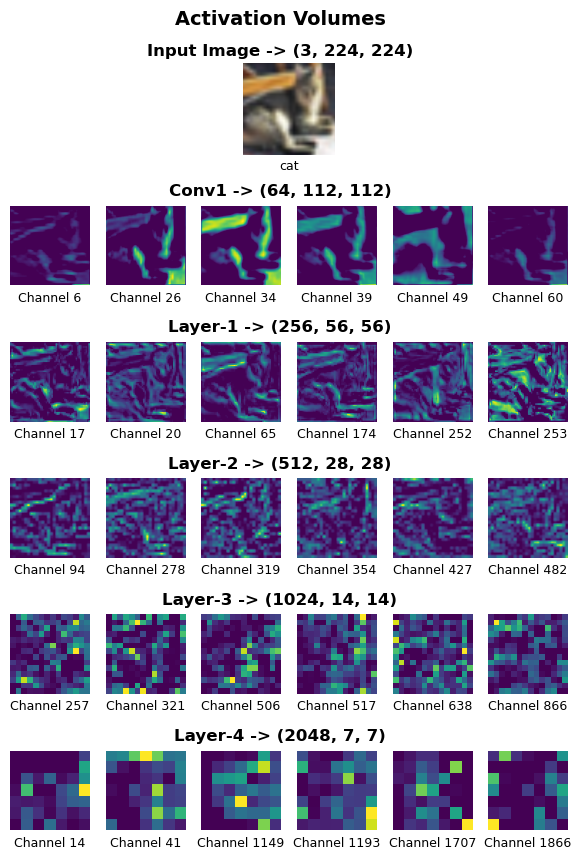

In [21]:
num_images = 2 # Number of images to plot
num_channels = 6 # Number of channels to plot for each layer
conv_layers = [resnet50_classifier.relu, resnet50_classifier.layer1, resnet50_classifier.layer2, resnet50_classifier.layer3, resnet50_classifier.layer4]
conv_layer_names = ['Conv1', 'Layer-1', 'Layer-2', 'Layer-3', 'Layer-4']

visualize_activation_maps(resnet50_classifier, conv_layers, conv_layer_names, train_loader, num_channels, num_images, device=device)

##### (c) Reporting the accuracy

In [22]:
train_loss_resnet, train_acc_resnet = get_loss_accuracy(train_loader, resnet50_classifier, loss_fn, device)
val_loss_resnet, val_acc_resnet = get_loss_accuracy(val_loader, resnet50_classifier, loss_fn, device)
test_loss_resnet, test_acc_resnet = get_loss_accuracy(test_loader, resnet50_classifier, loss_fn, device)

print(f'Train Accuracy: {train_acc_resnet:.2f} | Validation Accuracy: {val_acc_resnet:.2f} | Test Accuracy: {test_acc_resnet:.2f}')

Train Accuracy: 90.77 | Validation Accuracy: 77.40 | Test Accuracy: 77.44


##### (d) Visualizing the bottleneck feature (tSNE)

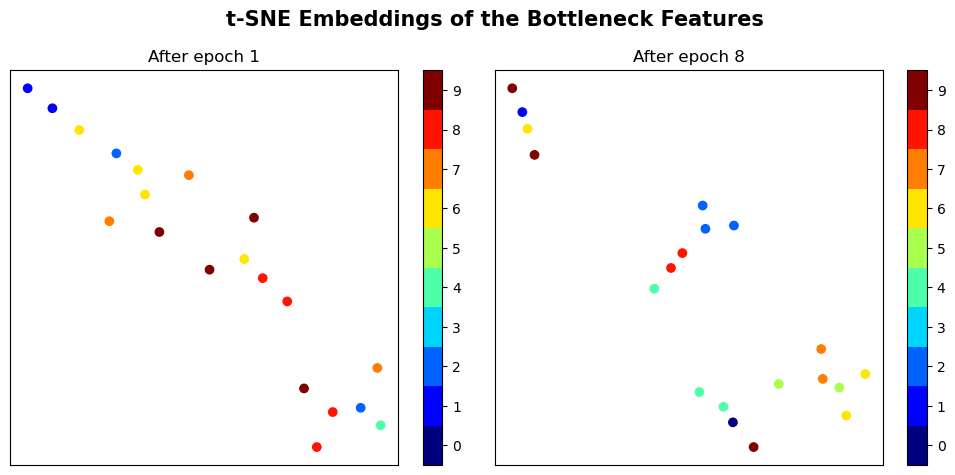

In [23]:
plot_tSNE_features(*bottleneck_features_resnet, num_epochs=epochs_resnet, title='t-SNE Embeddings of the Bottleneck Features')

In [24]:
# Free up GPU memory
del resnet50_classifier

#### (e) Comparing AlexNet and ResNet50

ResNet achieves a higher accuracy than AlexNet. This is because ResNet uses skip connections which helps in avoiding the vanishing gradient problem. Also, ResNet uses batch normalization which helps in faster convergence. However since ResNet is very deep, it takes a long time to train.

### 2) Time Series Models

#### Loading and preprocessing the data

In [38]:
from io import open
import glob
import os
import unicodedata

all_letters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"
n_letters = len(all_letters)

def unicodetoascii(s) -> str:
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters)

def load_data(data_path) -> tuple[list[str], list[tuple[str, str]]]:
    categories = []
    data = []
    for filename in glob.glob(data_path):
        language = os.path.splitext(os.path.basename(filename))[0]
        categories.append(language)
        data += [(unicodetoascii(line), language) for line in open(filename, encoding='utf-8').read().strip().split('\n')]
    np.random.shuffle(data)
    return categories, data

 # Convert a line to a tensor using one-hot encoding (line_length, 1, n_letters)
def line_to_tensor(line) -> torch.Tensor:
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][all_letters.find(letter)] = 1
    return tensor

data_path = './data/names/*.txt'
languages, name_language = load_data(data_path)
n_languages = len(languages)

print(f'Number of languages: {n_languages}')
print(f'Languages: {languages}\n')
print(f'Number of names: {len(name_language)}')
print(f'Some names: {name_language[:5]}')

Number of languages: 18
Languages: ['German', 'Scottish', 'French', 'Czech', 'Spanish', 'Japanese', 'Greek', 'Dutch', 'English', 'Italian', 'Irish', 'Chinese', 'Vietnamese', 'Russian', 'Arabic', 'Korean', 'Polish', 'Portuguese']

Number of names: 20074
Some names: [('Romeijn', 'Dutch'), ('Hellewege', 'German'), ('Pohilevich', 'Russian'), ('Teshima', 'Japanese'), ('Gray', 'English')]


#### Training loop

In [44]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, loss_fn: nn.Module, batch_size: int = 100, max_epochs: int = 1000, device: torch.device = torch.device('cpu'), verbose: bool = False, plot_every: int = 10) -> tuple[list[float], list[float]]:
    ''' Train the model for the given number of epochs and return the training losses'''
    losses = []
    for epoch in tqdm(range(1, max_epochs+1)):
        np.random.shuffle(name_language)
        avg_loss = 0
        for i, (name, language) in enumerate(name_language):
            if i % batch_size == 0: 
                optimizer.zero_grad()
            name_tensor = line_to_tensor(name).to(device)
            language_tensor = torch.tensor([languages.index(language)], dtype=torch.long).to(device)
            
            # Compute prediction, loss and backpropagate
            pred = model(name_tensor)
            loss = loss_fn(pred, language_tensor)
            loss.backward()
            avg_loss += loss.item()
            
            # Update the weights after every batch
            if i % batch_size == batch_size-1:
                optimizer.step()
            
            # Plot the loss every plot_every batches
            if i % (batch_size*plot_every) == (batch_size*plot_every)-1:
                losses.append(avg_loss/(plot_every*batch_size))
                avg_loss = 0
        
        # Print the loss every epoch         
        if verbose:
            guess = language_from_output(pred)
            correct = '✓' if guess == language else f'✗ ({language})'
            print(f'Epoch {epoch:<2} -> Loss: {losses[-1]:.4f} | Accuracy: {get_accuracy(model, device):.2f}% | Name: {name:<11} | Language: {guess:<10} {correct}')
            
    return losses

#### Utility functions

In [45]:
def language_from_output(output: torch.Tensor) -> str:
    ''' Get the language prediction from the output of the model'''
    top_n, top_i = output.topk(1)
    language_i = top_i[0].item()
    return languages[language_i]
    
def predict(model: nn.Module, name: str, device: torch.device = torch.device('cpu')) -> tuple[str, str]:
    ''' Predict the language of the given name'''
    name_tensor = line_to_tensor(name).to(device)
    with torch.no_grad():
        pred = model(name_tensor)
    return name, language_from_output(pred)

def plot_losses(losses: list, title: str = 'Loss vs Iterations'):
    ''' Plot the losses vs iterations'''
    plt.figure(figsize=(7.5, 3))
    plt.title(title)
    plt.plot(np.arange(1, len(losses)+1), losses)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

def get_accuracy(model: nn.Module, device: torch.device = torch.device('cpu')) -> float:
    ''' Get the accuracy of the model on the validation set'''
    correct = 0
    for name, language in name_language:
        _, pred = predict(model, name, device)
        if pred == language: correct += 1
    return 100*correct/len(name_language)

def get_category_accuracies(model: nn.Module, device: torch.device = torch.device('cpu')) -> dict[str, float]:
    ''' Get the accuracy of the model on each language'''
    language_correct = {language: 0 for language in languages}
    language_total = {language: 0 for language in languages}
    for name, language in name_language:
        _, pred = predict(model, name, device)
        if pred == language: language_correct[language] += 1
        language_total[language] += 1
    return {language: f'{language_correct[language]}/{language_total[language]}' for language in languages}

def plot_confusion_matrix(model: nn.Module, device: torch.device = torch.device('cpu'), title: str = 'Confusion Matrix'):
    ''' Plot the confusion matrix of the model on the validation set'''
    confusion = torch.zeros(n_languages, n_languages)
    for name, language in name_language:
        _, pred = predict(model, name, device)
        confusion[languages.index(language)][languages.index(pred)] += 1
    confusion = confusion/confusion.sum(1, keepdim=True)
    
    plt.figure(figsize=(7.5, 7.5))
    plt.title(title)
    plt.imshow(confusion, cmap='hot')
    plt.xticks(np.arange(n_languages), languages, rotation=90)
    plt.yticks(np.arange(n_languages), languages)
    plt.xlabel('Predicted Language')
    plt.ylabel('Actual Language')
    plt.colorbar()
    plt.show()

#### Training Hyperparameters

In [47]:
n_hidden = 128 # Number of hidden units in the RNN/GRU/LSTM
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam
learning_rate = 0.005
max_epochs = 10
batch_size = 100

#### (a) RNN

In [48]:
class RNN_classifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(RNN_classifier, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        outputs, hidden = self.rnn(x) # out.shape = (seq_len, batch, hidden_size)
        output = self.output(outputs[-1]) # We only need the last output
        output = self.softmax(output)
        return output
    
rnn_classifier = RNN_classifier(n_letters, n_hidden, n_languages).to(device)
print_model_summary(rnn_classifier)

 Model Summary 
Total number of parameters: 26258
RNN_classifier(
  (rnn): RNN(57, 128)
  (output): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1  -> Loss: 0.9945 | Accuracy: 71.30% | Name: Dudnikov    | Language: Russian    ✓
Epoch 2  -> Loss: 0.8799 | Accuracy: 75.14% | Name: Dmohovsky   | Language: Russian    ✓
Epoch 3  -> Loss: 0.7076 | Accuracy: 78.93% | Name: Kotara      | Language: Japanese   ✓
Epoch 4  -> Loss: 0.7015 | Accuracy: 79.21% | Name: Higashikuni | Language: Russian    ✗ (Japanese)
Epoch 5  -> Loss: 0.6511 | Accuracy: 80.92% | Name: Ott         | Language: English    ✗ (Russian)
Epoch 6  -> Loss: 0.6605 | Accuracy: 81.81% | Name: Pispinis    | Language: Greek      ✓
Epoch 7  -> Loss: 0.6311 | Accuracy: 82.08% | Name: Zhavrid     | Language: Russian    ✓
Epoch 8  -> Loss: 0.5986 | Accuracy: 84.68% | Name: Eatherington | Language: English    ✓
Epoch 9  -> Loss: 0.5564 | Accuracy: 84.87% | Name: Samios      | Language: Arabic     ✗ (Greek)
Epoch 10 -> Loss: 0.4999 | Accuracy: 84.14% | Name: Fabre       | Language: English    ✗ (French)


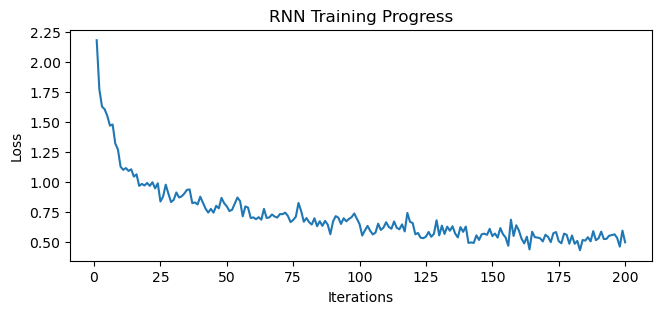

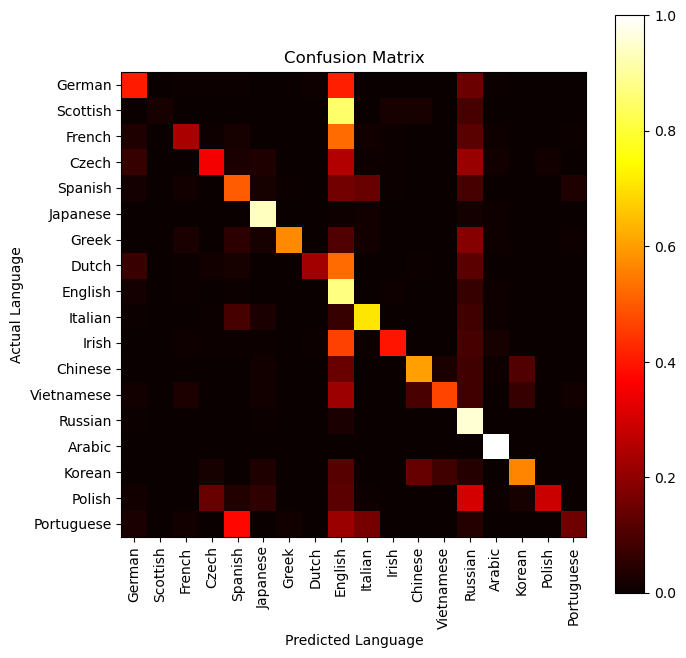

Accuracy: {'German': '294/724', 'Scottish': '2/100', 'French': '67/277', 'Czech': '182/519', 'Spanish': '150/298', 'Japanese': '928/991', 'Greek': '116/203', 'Dutch': '68/297', 'English': '3200/3668', 'Italian': '503/709', 'Irish': '92/232', 'Chinese': '162/268', 'Vietnamese': '34/73', 'Russian': '8989/9408', 'Arabic': '2000/2000', 'Korean': '53/94', 'Polish': '40/139', 'Portuguese': '11/74'}


In [49]:
# Train the model
optimizer_rnn = optimizer(rnn_classifier.parameters(), lr=learning_rate)
losses_rnn = train(rnn_classifier, optimizer_rnn, loss_fn, batch_size, max_epochs, device, verbose=True)

plot_losses(losses_rnn, title='RNN Training Progress')
plot_confusion_matrix(rnn_classifier, device=device)
print(f'Accuracy: {get_category_accuracies(rnn_classifier, device)}')

#### (b) GRU

In [50]:
class GRU_classifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(GRU_classifier, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        outputs, hidden = self.gru(x) # outputs.shape = (seq_len, batch, hidden_size)
        output = self.output(outputs[-1])
        output = self.softmax(output)
        return output
    
gru_classifier = GRU_classifier(n_letters, n_hidden, n_languages).to(device)
print_model_summary(gru_classifier)

 Model Summary 
Total number of parameters: 74130
GRU_classifier(
  (gru): GRU(57, 128)
  (output): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1  -> Loss: 0.9235 | Accuracy: 75.26% | Name: Valberh     | Language: Russian    ✓
Epoch 2  -> Loss: 0.7085 | Accuracy: 80.62% | Name: Macfarland  | Language: English    ✗ (Irish)
Epoch 3  -> Loss: 0.5602 | Accuracy: 83.56% | Name: Davletyarov | Language: Russian    ✓
Epoch 4  -> Loss: 0.4960 | Accuracy: 85.85% | Name: Ohme        | Language: English    ✗ (German)
Epoch 5  -> Loss: 0.4116 | Accuracy: 87.76% | Name: Tahan       | Language: Arabic     ✓
Epoch 6  -> Loss: 0.3903 | Accuracy: 89.89% | Name: Takashita   | Language: Japanese   ✓
Epoch 7  -> Loss: 0.3850 | Accuracy: 91.10% | Name: Tzaizer     | Language: Russian    ✓
Epoch 8  -> Loss: 0.3562 | Accuracy: 92.22% | Name: Ebdon       | Language: English    ✓
Epoch 9  -> Loss: 0.2665 | Accuracy: 93.17% | Name: Ufimtsev    | Language: Russian    ✓
Epoch 10 -> Loss: 0.2228 | Accuracy: 93.99% | Name: Onoda       | Language: Japanese   ✓


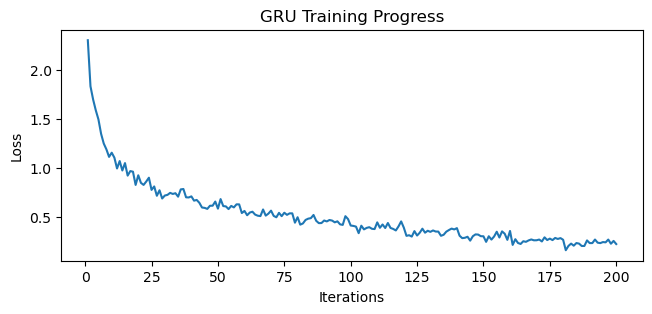

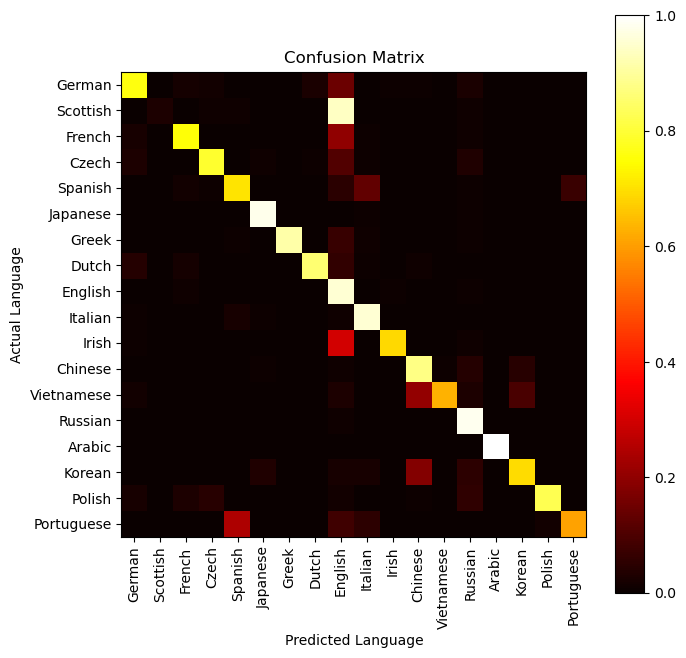

Accuracy: {'German': '551/724', 'Scottish': '3/100', 'French': '208/277', 'Czech': '410/519', 'Spanish': '210/298', 'Japanese': '969/991', 'Greek': '185/203', 'Dutch': '255/297', 'English': '3505/3668', 'Italian': '676/709', 'Irish': '160/232', 'Chinese': '235/268', 'Vietnamese': '46/73', 'Russian': '9230/9408', 'Arabic': '2000/2000', 'Korean': '65/94', 'Polish': '115/139', 'Portuguese': '45/74'}


In [51]:
optimizer_gru = optimizer(gru_classifier.parameters(), lr=learning_rate)
losses_gru = train(gru_classifier, optimizer_gru, loss_fn, batch_size, max_epochs, device, verbose=True)

plot_losses(losses_gru, title='GRU Training Progress')
plot_confusion_matrix(gru_classifier, device=device)
print(f'Accuracy: {get_category_accuracies(gru_classifier, device)}')

#### (c) LSTM

In [52]:
class LSTM_classifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(LSTM_classifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        outputs, hidden = self.lstm(x) # outputs.shape = (seq_len, batch, hidden_size)
        output = self.output(outputs[-1])
        output = self.softmax(output)
        return output
    
lstm_classifier = LSTM_classifier(n_letters, n_hidden, n_languages).to(device)
print_model_summary(lstm_classifier)

 Model Summary 
Total number of parameters: 98066
LSTM_classifier(
  (lstm): LSTM(57, 128)
  (output): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1  -> Loss: 0.9352 | Accuracy: 71.56% | Name: Yatsunov    | Language: Russian    ✓
Epoch 2  -> Loss: 0.7419 | Accuracy: 78.36% | Name: Dukes       | Language: English    ✓
Epoch 3  -> Loss: 0.6384 | Accuracy: 80.60% | Name: Vorogushin  | Language: Russian    ✓
Epoch 4  -> Loss: 0.5779 | Accuracy: 83.64% | Name: Regent      | Language: English    ✓
Epoch 5  -> Loss: 0.4921 | Accuracy: 85.97% | Name: Numajiri    | Language: Japanese   ✓
Epoch 6  -> Loss: 0.4573 | Accuracy: 87.10% | Name: Zavolokin   | Language: Russian    ✓
Epoch 7  -> Loss: 0.4470 | Accuracy: 89.64% | Name: Balarev     | Language: Russian    ✓
Epoch 8  -> Loss: 0.3673 | Accuracy: 90.81% | Name: Baikowski   | Language: Russian    ✓
Epoch 9  -> Loss: 0.3777 | Accuracy: 91.52% | Name: Novosilsky  | Language: Russian    ✓
Epoch 10 -> Loss: 0.3039 | Accuracy: 93.13% | Name: Jadkevich   | Language: Russian    ✓


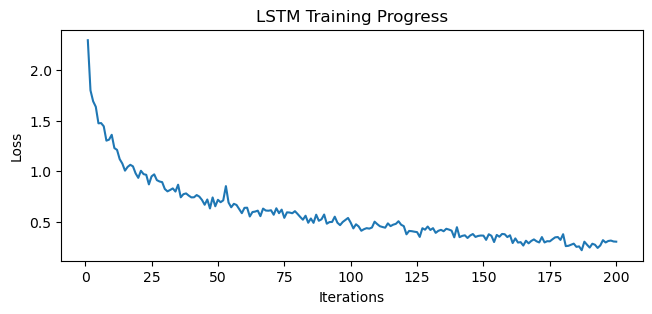

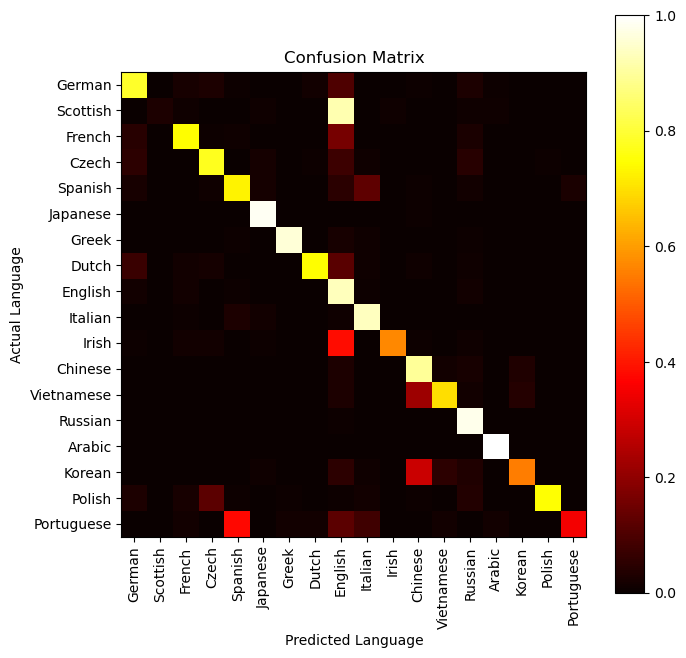

Accuracy: {'German': '570/724', 'Scottish': '3/100', 'French': '206/277', 'Czech': '402/519', 'Spanish': '217/298', 'Japanese': '977/991', 'Greek': '195/203', 'Dutch': '221/297', 'English': '3424/3668', 'Italian': '662/709', 'Irish': '132/232', 'Chinese': '240/268', 'Vietnamese': '51/73', 'Russian': '9212/9408', 'Arabic': '2000/2000', 'Korean': '52/94', 'Polish': '104/139', 'Portuguese': '26/74'}


In [53]:
optimizer_lstm = optimizer(lstm_classifier.parameters(), lr=learning_rate)
losses_lstm = train(lstm_classifier, optimizer_lstm, loss_fn, batch_size, max_epochs, device, verbose=True)

plot_losses(losses_lstm, title='LSTM Training Progress')
plot_confusion_matrix(lstm_classifier, device=device)
print(f'Accuracy: {get_category_accuracies(lstm_classifier, device)}')

As we can see, GRu and LSTM converge better and faster than vanilla RNNs.